# federated-ml-health 
**Notatnik przystosowany do zajęć z SIwIB**.
* aktualizacja do nowszej wersji biblioteki TF Federated
* uproszczenie kodu (usunięcie części związanej z *Differential Privacy*) i przygotowanie fragmentów kodu na potrzeby zajęć

---

Oryginalna wersja: https://github.com/google/federated-ml-health

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
# Instalacja TF Federated
%pip install --quiet --upgrade tensorflow-federated




# Przygotowanie danych

Na początku wykorzystamy zbiór `pima`. W dalszej kolejności będziemy pracować na odpowiednio przygotowanej wersji zbioru MIMIC-III (dostępny na eKursach).

In [2]:
import collections
import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import tensorflow_federated as tff
from collections import defaultdict 
from matplotlib.pyplot import figure
from numpy import loadtxt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [3]:
# Ukrycie części niestotnych logów
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
# Podmontowanie dysku Google
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
np.random.seed(42)
tf.random.set_seed(42)


In [6]:
# Ścieżki do plików przy założeniu, że pliki z danymi znajdują się w głównym katalogu na GDrive
# csv_fn = '/content/drive/MyDrive/pima.csv' 
csv_fn = 'mimic3-17f-in-hosp-mort.csv'  # 'content/drive/MyDrive/'
# W dalszej kolejności będziemy używać '/content/drive/MyDrive/mimic3.csv'
raw_ds = pd.read_csv(csv_fn)
num_col = raw_ds.shape[1]
# Zakładamy, że atrybut decyzyjny jest zawsze w ostatniej kolumnie
X = raw_ds.iloc[:, 0:num_col-1].values
y = raw_ds.iloc[:, num_col-1].values

In [7]:
raw_ds.shape

(35993, 20)

In [8]:
raw_ds.iloc[:, 0:num_col-1].head()

,age,glasgow_coma_scale,systolic_blood_pressure,heart_rate,body_temperature,pao2_fio2_ratio,urinary_output,serum_urea_nitrogen_level,white_blood_cells_count,serum_bicarbonate_level,sodium_level,potassium_level,bilirubin_level,aids,hematologic_malignancy,metastatic_cancer,admission_type_medical,admission_type_surgical_scheduled,admission_type_surgical_unscheduled
0,35.48,15.0,201.0,110.0,37.777778,NaN,0.5,3900.0,11.9,21.0,144.0,3.8,0.5,0,0,0,1,0,0
1,59.91,14.0,146.0,77.0,36.777778,NaN,3.3,2580.0,17.9,21.0,133.0,5.0,5.5,0,0,0,1,0,0
2,48.92,15.0,149.0,113.0,36.555557,NaN,NaN,2950.0,13.6,24.0,131.0,3.7,NaN,0,1,0,1,0,0
3,73.82,15.0,164.0,108.0,37.722223,NaN,NaN,1290.0,12.3,27.0,140.0,4.1,NaN,0,0,0,0,0,1
4,60.80,15.0,132.0,88.0,NaN,126.0,NaN,2490.0,17.3,24.0,143.0,3.1,NaN,0,0,0,0,0,1


In [9]:
raw_ds.iloc[:, num_col-1].head()

0    0
1    0
2    0
3    0
4    0
Name: in_hospital_mortality, dtype: int64

In [10]:
raw_ds.iloc[:, num_col-1].value_counts()

0    32433
1     3560
Name: in_hospital_mortality, dtype: int64

## Podział na część uczącą i testującą

Tym razem porządniej, niż w oryginalnym notatniku :) -- `scaler` oraz `imputer` są uczone na danych uczących i stosowane do danych testowych.

In [11]:
TRAIN_PROPORTION = 0.8
NUM_FEATURES = X.shape[1]
NUM_ROUNDS = 12

n_train = round(TRAIN_PROPORTION * X.shape[0])
n_test = X.shape[0] - n_train

X_train = X[:n_train]
y_train =  y[:n_train]
X_test = X[n_train:]
y_test =  y[n_train:]

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline 

preprocessor = make_pipeline(SimpleImputer(), StandardScaler())

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


# Podejście scentralizowane

## Regresja - scikit-learn


Testujemy kilka wariantów regresji logistycznej, aby uzyskać *baseline*.

In [13]:
sk_model = LogisticRegression(random_state=42).fit(X_train, y_train)
proba_test = sk_model.predict_proba(X_test)[:,1]
fpr_sk, tpr_sk, threshold_sk = sklearn.metrics.roc_curve(y_test, proba_test)
auc_sk = sklearn.metrics.auc(fpr_sk, tpr_sk)
print(f'AUC-LIN = {auc_sk:.4}')

AUC-LIN = 0.7607


## Regresja - TF

Implementujemy regresję logistyczną w TF. Stworzony model (`tf_model`) wykorzystuje `Adam`-a. Wyjaśnienie autorów notatnika: *Adam optimization method is used to mimic the sklearn solver as close as possible (leveraging second derivatives of gradient).*

In [14]:
# dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(n_train)
# dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(n_train)

In [15]:
# Prosty model - LR
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.Dense(
          1,
          activation='sigmoid',
          input_shape=(NUM_FEATURES,),
          kernel_regularizer=tf.keras.regularizers.l2(0.01),
      )
  ])

# Bardziej złożony model - MLP
def create_keras_model_deeper():
  initializer = tf.keras.initializers.GlorotNormal(seed=10)
  m = tf.keras.models.Sequential()
  m.add(tf.keras.Input(shape=(NUM_FEATURES,)))
  m.add(tf.keras.layers.Dense(6, activation='sigmoid', kernel_initializer=initializer))
  m.add(tf.keras.layers.Dense(3, activation='sigmoid', kernel_initializer=initializer))
  m.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.0001, l2=0.01)))
  return m
  

In [16]:
tf_model = create_keras_model()
tf_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.5),   
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.AUC(name='auc'),
  ]
)

batch_size = round(n_train/3)


In [17]:
# tf_model.fit(dataset_train, validation_data=dataset_test, epochs=NUM_ROUNDS, batch_size=batch_size, verbose=1, use_multiprocessing=True)

tf_model.fit(X_train, y_train, epochs=NUM_ROUNDS, batch_size=batch_size, verbose=1, use_multiprocessing=True)


Epoch 1/12
3/3 [==============================] - 1s 13ms/step - loss: 0.7091 - accuracy: 0.6372 - auc: 0.5799
Epoch 2/12
3/3 [==============================] - 0s 7ms/step - loss: 0.3886 - accuracy: 0.8657 - auc: 0.6760
Epoch 3/12
3/3 [==============================] - 0s 7ms/step - loss: 0.3517 - accuracy: 0.9004 - auc: 0.5914
Epoch 4/12
3/3 [==============================] - 0s 6ms/step - loss: 0.3541 - accuracy: 0.9011 - auc: 0.7126
Epoch 5/12
3/3 [==============================] - 0s 10ms/step - loss: 0.3643 - accuracy: 0.8996 - auc: 0.7457
Epoch 6/12
3/3 [==============================] - 0s 8ms/step - loss: 0.3535 - accuracy: 0.9003 - auc: 0.7469
Epoch 7/12
3/3 [==============================] - 0s 7ms/step - loss: 0.3481 - accuracy: 0.9030 - auc: 0.7336
Epoch 8/12
3/3 [==============================] - 0s 14ms/step - loss: 0.3323 - accuracy: 0.9031 - auc: 0.7458
Epoch 9/12
3/3 [==============================] - 0s 12ms/step - loss: 0.3135 - accuracy: 0.9024 - auc: 0.7604
Epoch 

In [18]:
proba_test = tf_model.predict(X_test)
fpr_tf, tpr_tf, threshold = sklearn.metrics.roc_curve(y_test, proba_test)
auc_tf = sklearn.metrics.auc(fpr_tf, tpr_tf)
print(f'AUC-TF = {auc_tf:0.4}')

225/225 [==============================] - 0s 2ms/step
AUC-TF = 0.7485


# Regresja - TF Federated

Utworzenie zbioru z danymi uczącymi, aby ułatwić przydział danych do poszczególnych klientów

In [19]:
df_X_train = pd.DataFrame(data=X_train, columns=raw_ds.columns[:-1])
df_y_train = pd.DataFrame(data=y_train, columns=raw_ds.columns[-1:])

Przypisanie identyfikatorów (indeksów) przykładów uczących do poszczególnych klientów. Obecnie wszyscy klienci otrzymują taką samą liczbę przykładów, przy czym rozkład klas nie jest zachowywany. Ta funkcja powinna zostać zmodyfikowna w ramach projektu.

In [20]:
def assign_samples_to_clients(data, n_clients):
    from sklearn.model_selection import KFold
    client_sample_ids = []
    kf = KFold(n_splits=n_clients, shuffle=True, random_state=42)
    for _, test_ids in kf.split(data):
        client_sample_ids.append(test_ids)
    return client_sample_ids

In [21]:
NUM_CLIENTS = 20
# NUM_PARTICIPATING_PER_ROUND = round(NUM_CLIENTS/3)

In [22]:
client_ids = list(range(NUM_CLIENTS))
client_sample_ids = assign_samples_to_clients(X_train, NUM_CLIENTS)

In [23]:
def create_client_dataset(data, labels, client_ids, client_sample_ids):
  def create_dataset_fn(client_id):
    sample_ids = client_sample_ids[client_id]
    return tf.data.Dataset.from_tensor_slices((data[sample_ids, :], labels[sample_ids]))

  return tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
      client_ids=client_ids,
      serializable_dataset_fn=create_dataset_fn)
  
def preprocess(dataset):
    card = dataset.cardinality()
    batch_size = 1 if card == tf.data.INFINITE_CARDINALITY or tf.data.UNKNOWN_CARDINALITY else round(card.numpy()/3)
    return dataset.batch(batch_size)

def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(id))
      for id in client_ids
  ]

In [24]:
client_dataset_train = create_client_dataset(X_train, y_train, client_ids, client_sample_ids)

In [25]:
spec_dataset = preprocess(client_dataset_train.create_tf_dataset_for_client(client_ids[0]))

def model_fn():
  keras_model = create_keras_model()
  return tff.learning.models.from_keras_model(
    keras_model,
    input_spec=spec_dataset.element_spec,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc')
    ]
  )
  
# Tworzymy iteracyjny proces uczący z wykorzystaniem bazowego algorytmu FedAvg
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.5), 
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
    use_experimental_simulation_loop = True
)

In [26]:
tff_auc = defaultdict(lambda:0)

In [27]:
# Zewnętrzna pętla pozwala na sprawdzanie różnej liczby klientów biorących udział w każdej rundzie obliczeń.
# Na potrzeby projektu należy założyć, że wszyscy klienci uczestniczą w obliczeniach

possible_num_clients_per_round = list(range(2, NUM_CLIENTS, 4))

if not NUM_CLIENTS in possible_num_clients_per_round:
  possible_num_clients_per_round.append(NUM_CLIENTS)

for num_clients_per_round in possible_num_clients_per_round:
  print(f"# participating clients = {num_clients_per_round}")
  
  state = trainer.initialize()
  tff_model = create_keras_model()

  for r in range(NUM_ROUNDS):
    participating_client_ids = np.random.choice(range(NUM_CLIENTS), size=num_clients_per_round, replace=False)
    print(f"round {r + 1}/{NUM_ROUNDS} | participants = {participating_client_ids}")
    federated_train_data = make_federated_data(client_dataset_train, participating_client_ids)
    state, metrics = trainer.next(state, federated_train_data)
    # print(n_clients, i_round, str(metrics))

  weights = trainer.get_model_weights(state)
  weights.assign_weights_to(tff_model)

  proba_test = tff_model.predict(X_test)
  fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(y_test, proba_test)
  auc_test = sklearn.metrics.auc(fpr_test, tpr_test)
  loss_test = tf.keras.losses.binary_crossentropy(y_test, np.reshape(proba_test, [-1]))
  print(f'AUC = {auc_test:0.4}, Loss={loss_test:0.4}')

  tff_auc[num_clients_per_round] = (auc_test, fpr_test, tpr_test)


# participating clients = 2
round 1/12 | participants = [ 0 17]
round 2/12 | participants = [19 16]
round 3/12 | participants = [10  7]
round 4/12 | participants = [ 0 18]
round 5/12 | participants = [5 2]
round 6/12 | participants = [3 1]
round 7/12 | participants = [13 10]
round 8/12 | participants = [17 18]
round 9/12 | participants = [17 11]
round 10/12 | participants = [4 9]
round 11/12 | participants = [2 6]
round 12/12 | participants = [14  3]
225/225 [==============================] - 0s 2ms/step
AUC = 0.539, Loss=0.9368
# participating clients = 6
round 1/12 | participants = [ 9  8  6 14 13  2]
round 2/12 | participants = [ 5 11  4 19  9  1]
round 3/12 | participants = [14 16 19 13  4 12]
round 4/12 | participants = [ 6 11  4  1 18  9]
round 5/12 | participants = [14  7 12  6 11  4]
round 6/12 | participants = [ 7  3  4 18  1 12]
round 7/12 | participants = [ 8  7  1  6  9 10]
round 8/12 | participants = [17  4  3 10  6 13]
round 9/12 | participants = [13 14 15 17  3  4]
round

### Przydział przykąłdów do klientów funkcją beta

In [28]:
def assign_samples_to_clients_beta(data, n_clients, alpha=2, beta=2):
    client_sample_ids = []
    indices = np.arange(data.shape[0]).tolist()
    total_samples = len(indices)

    # generate probabilities from beta
    probabilities = np.random.beta(alpha, beta, size=n_clients)
    total_probability = np.sum(probabilities)

    for probability in probabilities:
        num_indices = int(round(probability * total_samples / total_probability))
        client_indices = indices[:num_indices]
        indices = indices[num_indices:]
        total_probability -= probability
        client_sample_ids.append(client_indices)

    # distribute remaining indices evenly
    remainder = len(indices)
    for i, group in enumerate(client_sample_ids):
        if remainder > 0:
            group.append(indices[i % remainder])
    
    return client_sample_ids

In [29]:
# def assign_samples_to_clients_beta_old(data, n_clients, alpha=2, beta=2):
#     from sklearn.model_selection import KFold
#     client_sample_ids = []
#     kf = KFold(n_splits=n_clients, shuffle=True, random_state=42)
    
#     for i, (_, test_ids) in enumerate(kf.split(data)):
#         probabilities = np.random.beta(alpha, beta, size=len(test_ids))
#         client_sample_ids.append(test_ids[np.argsort(probabilities)])
    
#     return client_sample_ids

In [30]:
tff_beta = {}

for name, alpha, beta in [("average", 2, 2), ("low", 2, 5), ("high", 5, 2)]:
    print(f"# Processing {name}")

    client_sample_ids = assign_samples_to_clients_beta(
        X_train, NUM_CLIENTS, alpha=alpha, beta=beta
        )
    client_dataset_train = create_client_dataset(X_train, y_train, client_ids, client_sample_ids)
    trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.5), 
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
        use_experimental_simulation_loop = True
    )

    num_clients_per_round = NUM_CLIENTS
    print(f"# participating clients = {num_clients_per_round}")
    
    state = trainer.initialize()
    tff_model = create_keras_model()

    for r in range(NUM_ROUNDS):
      participating_client_ids = np.random.choice(range(NUM_CLIENTS), size=num_clients_per_round, replace=False)
      print(f"round {r + 1}/{NUM_ROUNDS} | participants = {participating_client_ids}")
      federated_train_data = make_federated_data(client_dataset_train, participating_client_ids)
      state, metrics = trainer.next(state, federated_train_data)
      # print(n_clients, i_round, str(metrics))

    weights = trainer.get_model_weights(state)
    weights.assign_weights_to(tff_model)

    proba_test = tff_model.predict(X_test)
    fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(y_test, proba_test)
    auc_test = sklearn.metrics.auc(fpr_test, tpr_test)
    loss_test = tf.keras.losses.binary_crossentropy(y_test, np.reshape(proba_test, [-1]))
    print(f'AUC = {auc_test:0.4}, Loss={loss_test:0.4}')

    tff_beta[name] = (auc_test, fpr_test, tpr_test)

# Processing average
# participating clients = 20
round 1/12 | participants = [10 19 16  8 12 18  5 17 15  1  7  2 13  0  4  3  6  9 14 11]
round 2/12 | participants = [15  6  5  1 12  2 19 16  4  9 10 11  3  7 17  0 18  8 14 13]
round 3/12 | participants = [ 9  0 15 14 16 11  2  4  5 17  7 18 19  3  6  8  1 12 10 13]
round 4/12 | participants = [12 10 13  7  9 14 11  1  3 17 19  0  6 18 15  4  5  2 16  8]
round 5/12 | participants = [13  9 15 10  6  0 18  1  4  3 11  8 14  7 12  5 19  2 16 17]
round 6/12 | participants = [12 17 16  0 19  5  6  3 13 18 10  4 15  7 14  8  9 11  1  2]
round 7/12 | participants = [19  6  3 13 14  8 17 10  9  2  7  1  0 16 18 11 12 15  4  5]
round 8/12 | participants = [ 1  9 16 17 11  5  2  6  3  4 13 14 12  8 19 10  0  7 15 18]
round 9/12 | participants = [ 7  8 14  0  2  5 13 16 19 11  3  1  6  4 10 15 17  9 18 12]
round 10/12 | participants = [ 0 13 11 19 17  3 14 10  4 18  8  9  6 16  5 15  2 12  1  7]
round 11/12 | participants = [ 8 14  2 18  3  4  

### Porównanie stworzonych modeli

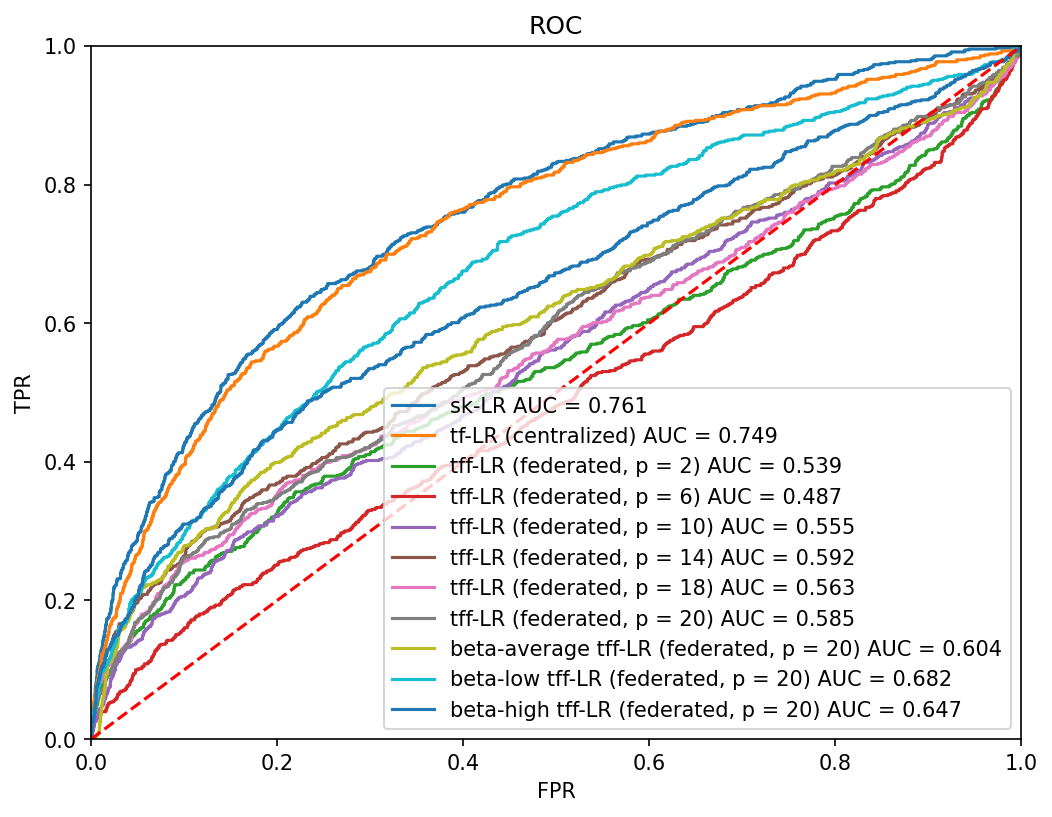

In [31]:
figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
plt.title('ROC')
plt.plot(fpr_sk, tpr_sk, label = f'sk-LR AUC = {auc_sk:0.3f}')
plt.plot(fpr_tf, tpr_tf, label = f'tf-LR (centralized) AUC = {auc_tf:0.3f}')
# Wyniki dla podejścia sfederowanego
for num_participants, (auc_tff, fpr_tff, tpr_tff) in tff_auc.items():
  plt.plot(fpr_tff, tpr_tff, label = f'tff-LR (federated, p = {num_participants}) AUC = {auc_tff:0.3f}')
for name, (auc_tff, fpr_tff, tpr_tff) in tff_beta.items():
  plt.plot(fpr_tff, tpr_tff, label = f'beta-{name} tff-LR (federated, p = {num_participants}) AUC = {auc_tff:0.3f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

# Regresja - TF Federated - funkcja zachowująca dystrybucję

Utworzenie zbioru z danymi uczącymi, aby ułatwić przydział danych do poszczególnych klientów

In [32]:
df_X_train = pd.DataFrame(data=X_train, columns=raw_ds.columns[:-1])
df_y_train = pd.DataFrame(data=y_train, columns=raw_ds.columns[-1:])

Poprawione przypisanie identyfikatorów (indeksów) przykładów uczących do poszczególnych klientów. Wszyscy klienci otrzymują taką samą liczbę przykładów, zachowując przy tym dystrybucję klas.

In [33]:
def assign_samples_to_clients_v2(data, targets, n_clients):
    from sklearn.model_selection import StratifiedKFold
    client_sample_ids = []
    skf = StratifiedKFold(n_splits=n_clients, shuffle=True, random_state=42)
    for train_ids, test_ids in skf.split(data, targets):
        client_sample_ids.append(test_ids)
    return client_sample_ids

In [34]:
def assign_samples_to_clients_experiment(X: pd.DataFrame, y: pd.Series, n_clients: int):
    client_sample_ids = [[] for _ in range(n_clients)]

    data = pd.DataFrame(X)
    data["target"] = pd.Series(y)
    grouped_data = data.groupby("target")

    class_counts = grouped_data.size().values
    per_client_counts = class_counts // n_clients

    # assign samples to clients, keeping class distributuion
    for class_idx, group in grouped_data:
        class_samples = group.index.tolist()
        np.random.shuffle(class_samples)

        for client_idx in range(n_clients):
            start_idx = client_idx * per_client_counts[class_idx]
            end_idx = (client_idx + 1) * per_client_counts[class_idx]
            client_sample_ids[client_idx].extend(class_samples[start_idx:end_idx])

    return client_sample_ids

In [35]:
NUM_CLIENTS = 20
# NUM_PARTICIPATING_PER_ROUND = round(NUM_CLIENTS/3)

In [36]:
client_ids = list(range(NUM_CLIENTS))
client_sample_ids = assign_samples_to_clients_v2(X_train, y_train, NUM_CLIENTS)

In [37]:
np.array(client_sample_ids).shape

<ipython-input-37-9e9cf3234a7b>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(client_sample_ids).shape


(20,)

In [38]:
client_dataset_train = create_client_dataset(X_train, y_train, client_ids, client_sample_ids)

In [39]:
spec_dataset = preprocess(client_dataset_train.create_tf_dataset_for_client(client_ids[0]))
  
# Tworzymy iteracyjny proces uczący z wykorzystaniem bazowego algorytmu FedAvg
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.5), 
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
    use_experimental_simulation_loop = True
)

In [40]:
tff_auc = defaultdict(lambda:0)

In [41]:
# Zewnętrzna pętla pozwala na sprawdzanie różnej liczby klientów biorących udział w każdej rundzie obliczeń.
# Na potrzeby projektu należy założyć, że wszyscy klienci uczestniczą w obliczeniach

possible_num_clients_per_round = list(range(2, NUM_CLIENTS, 4))

if not NUM_CLIENTS in possible_num_clients_per_round:
  possible_num_clients_per_round.append(NUM_CLIENTS)

for num_clients_per_round in possible_num_clients_per_round:
  print(f"# participating clients = {num_clients_per_round}")
  
  state = trainer.initialize()
  tff_model = create_keras_model()

  for r in range(NUM_ROUNDS):
    participating_client_ids = np.random.choice(range(NUM_CLIENTS), size=num_clients_per_round, replace=False)
    print(f"round {r + 1}/{NUM_ROUNDS} | participants = {participating_client_ids}")
    federated_train_data = make_federated_data(client_dataset_train, participating_client_ids)
    state, metrics = trainer.next(state, federated_train_data)
    # print(n_clients, i_round, str(metrics))

  weights = trainer.get_model_weights(state)
  weights.assign_weights_to(tff_model)

  proba_test = tff_model.predict(X_test)
  fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(y_test, proba_test)
  auc_test = sklearn.metrics.auc(fpr_test, tpr_test)
  loss_test = tf.keras.losses.binary_crossentropy(y_test, np.reshape(proba_test, [-1]))
  print(f'AUC = {auc_test:0.4}, Loss={loss_test:0.4}')

  tff_auc[num_clients_per_round] = (auc_test, fpr_test, tpr_test)


# participating clients = 2
round 1/12 | participants = [14 17]
round 2/12 | participants = [18  3]
round 3/12 | participants = [12  1]
round 4/12 | participants = [ 0 15]
round 5/12 | participants = [ 7 19]
round 6/12 | participants = [12 13]
round 7/12 | participants = [10 18]
round 8/12 | participants = [5 1]
round 9/12 | participants = [ 0 18]
round 10/12 | participants = [ 4 14]
round 11/12 | participants = [16  6]
round 12/12 | participants = [19  3]
225/225 [==============================] - 0s 2ms/step
AUC = 0.5031, Loss=1.187
# participating clients = 6
round 1/12 | participants = [17  2  0  9  1 14]
round 2/12 | participants = [ 8  1 16 13  3 15]
round 3/12 | participants = [ 8 12 15  6  5  1]
round 4/12 | participants = [ 7  2  4 17 18 19]
round 5/12 | participants = [ 6 12  0  8 13  1]
round 6/12 | participants = [12  1 10 19  2 16]
round 7/12 | participants = [10  0 17 11  8 15]
round 8/12 | participants = [ 7 14  1  4  2  6]
round 9/12 | participants = [12 11 19 18 14 17]

### Porównanie stworzonych modeli (zachowanie dystrybucji)

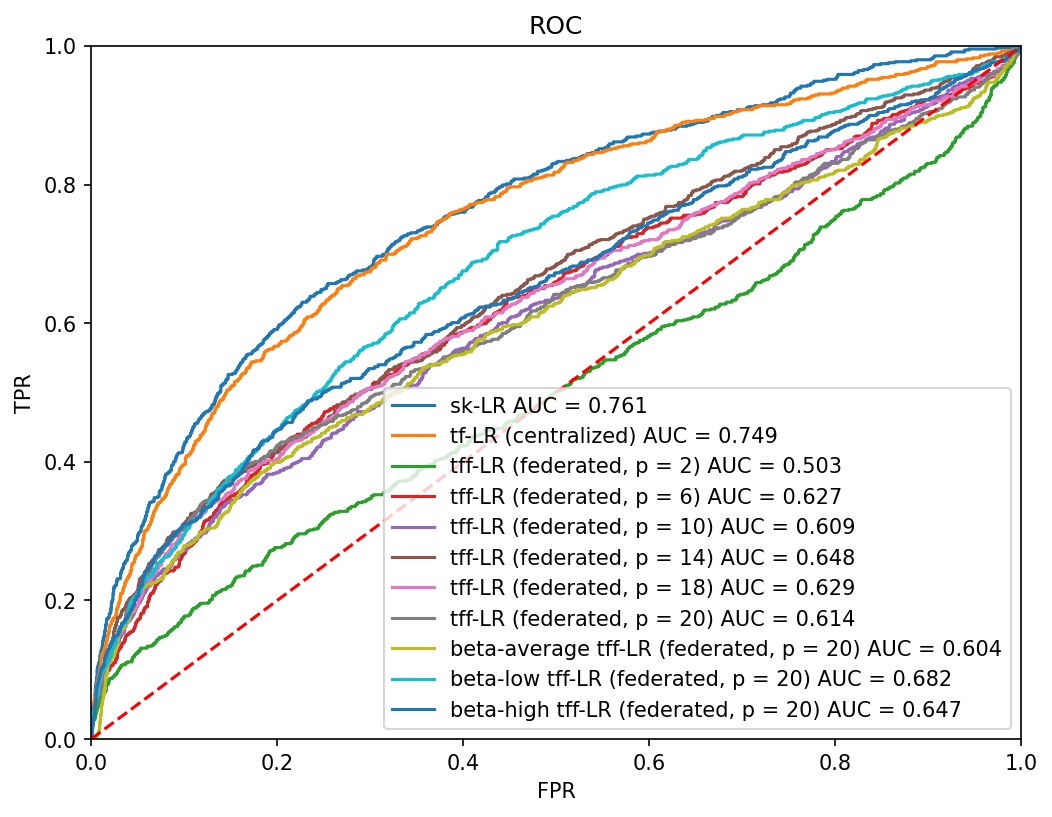

In [42]:
figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
plt.title('ROC')
plt.plot(fpr_sk, tpr_sk, label = f'sk-LR AUC = {auc_sk:0.3f}')
plt.plot(fpr_tf, tpr_tf, label = f'tf-LR (centralized) AUC = {auc_tf:0.3f}')
# Wyniki dla podejścia sfederowanego
for num_participants, (auc_tff, fpr_tff, tpr_tff) in tff_auc.items():
  plt.plot(fpr_tff, tpr_tff, label = f'tff-LR (federated, p = {num_participants}) AUC = {auc_tff:0.3f}')
for name, (auc_tff, fpr_tff, tpr_tff) in tff_beta.items():
  plt.plot(fpr_tff, tpr_tff, label = f'beta-{name} tff-LR (federated, p = {num_participants}) AUC = {auc_tff:0.3f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()